# Лабораторная работа №1
## Выполнил: Концебалов О.С.
## Группа: М8О-409Б-22

### Набор данных для задачи классификации

В качестве датасета для решения задачи классификации был выбран **[Heart Disease Dataset](https://www.kaggle.com/code/desalegngeb/heart-disease-predictions)**

**Практическая задача:** автоматизированный скрининг риска сердечно-сосудистых заболеваний по физиологическим показателям критически важен для поликлиник и страховых программ, чтобы своевременно выявлять пациентов с высоким риском подобных заболеваний и заблаговременно начинать лечение

### Набор данных для задачи регрессии

В качестве датасета для решения задачи регрессии был выбран **[House Prices Dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)**

**Практическая задача:** прогноз рыночной стоимости жилых домов по характеристикам объекта критически важен для агентств недвижимости, банков и страховых, чтобы назначать справедливую цену и оценку залога, снижать финансовые риски и время экспозиции

## KNN

Прочитаем наш датасет

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif

df = pd.read_csv('heart.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None


Посмотрим на распределение таргета, разделим выборку на тренировочную и тестовую

In [3]:
print("распределение таргета")
print(df['target'].value_counts())

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"размер трейна {X_train.shape}")
print(f"размер теста {X_test.shape}")

распределение таргета
1    526
0    499
Name: target, dtype: int64
размер трейна (820, 13)
размер теста (205, 13)


Обучим обычную библиотечную модель и посмотрим точность на кроссвалидации

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled, y_train)

y_pred_baseline = knn_baseline.predict(X_test_scaled)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
cv_scores_baseline = cross_val_score(knn_baseline, X_train_scaled, y_train, cv=5)

print('\nbase')
print(f"accuracy на тесте {accuracy_baseline:.4f}")
print(f"среднее accuracy на пяти фолдах {cv_scores_baseline.mean():.4f} (+/- {cv_scores_baseline.std() * 2:.4f})")


base
accuracy на тесте 0.8634
среднее accuracy на пяти фолдах 0.8500 (+/- 0.0738)


Получили хороший результат, теперь попробуем сделать подбор параметров

In [5]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print('\ngridsearch')
print(f"параметры {grid_search.best_params_}")
print(f"CV score {grid_search.best_score_:.4f}")

knn_improved = grid_search.best_estimator_
y_pred_improved = knn_improved.predict(X_test_scaled)

accuracy_improved = accuracy_score(y_test, y_pred_improved)

print('\ngrid')
print(f"accuracy на тесте {accuracy_improved:.4f}")
print(f"дельта {accuracy_improved - accuracy_baseline:.4f}")


gridsearch
параметры {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
CV score 0.9902

grid
accuracy на тесте 1.0000
дельта 0.1366


Получили очень хорошую точность, разница с базовой моделью небольшая
Теперь сделаем свою имплементацию

In [6]:
class CustomKNN:
    def __init__(self, n_neighbors=5, weights='uniform', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train = None
        self.y_train = None
        
    def _calculate_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':
            return np.sum(np.abs(x1 - x2) ** 3) ** (1/3)
        else:
            raise ValueError("ALARM")
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.values if hasattr(y, 'values') else y
        return self
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = []
            for i in range(len(self.X_train)):
                dist = self._calculate_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            neighbors = distances[:self.n_neighbors]
            
            if self.weights == 'uniform':
                votes = {}
                for _, label in neighbors:
                    votes[label] = votes.get(label, 0) + 1
                prediction = max(votes.items(), key=lambda x: x[1])[0]
            else:
                weighted_votes = {}
                for dist, label in neighbors:
                    weight = 1 / (dist + 1e-8)
                    weighted_votes[label] = weighted_votes.get(label, 0) + weight
                prediction = max(weighted_votes.items(), key=lambda x: x[1])[0]
            
            predictions.append(prediction)
        
        return np.array(predictions)

custom_knn = CustomKNN(n_neighbors=5, weights='uniform', metric='euclidean')
custom_knn.fit(X_train_scaled, y_train)
y_pred_custom = custom_knn.predict(X_test_scaled)

accuracy_custom = accuracy_score(y_test, y_pred_custom)

print('\nкастом кнн')
print(f"accuracy: {accuracy_custom:.4f}")
print(f"дельта между стоком {accuracy_custom - accuracy_baseline:.4f}")


кастом кнн
accuracy: 0.8634
дельта между стоком 0.0000


Наша самописная модель показала хорошую точнсть - такая же, что и библиотечная. Можно сделать вывод, что все написано верно

In [7]:
custom_knn_improved = CustomKNN(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights'],
    metric=grid_search.best_params_['metric']
)
custom_knn_improved.fit(X_train_scaled, y_train)
y_pred_custom_improved = custom_knn_improved.predict(X_test_scaled)

accuracy_custom_improved = accuracy_score(y_test, y_pred_custom_improved)

print('\nулучшенный кастом')
print(f"accuracy {accuracy_custom_improved:.4f}")
print(f"дельта между библиотечной {accuracy_custom_improved - accuracy_improved:.4f}")


улучшенный кастом
accuracy 1.0000
дельта между библиотечной 0.0000


Проверка на параметрах грида также показала что все работает корректно

                 Model  Accuracy
0         Baseline KNN  0.863415
1         Improved KNN  1.000000
2           Custom KNN  0.863415
3  Custom Improved KNN  1.000000


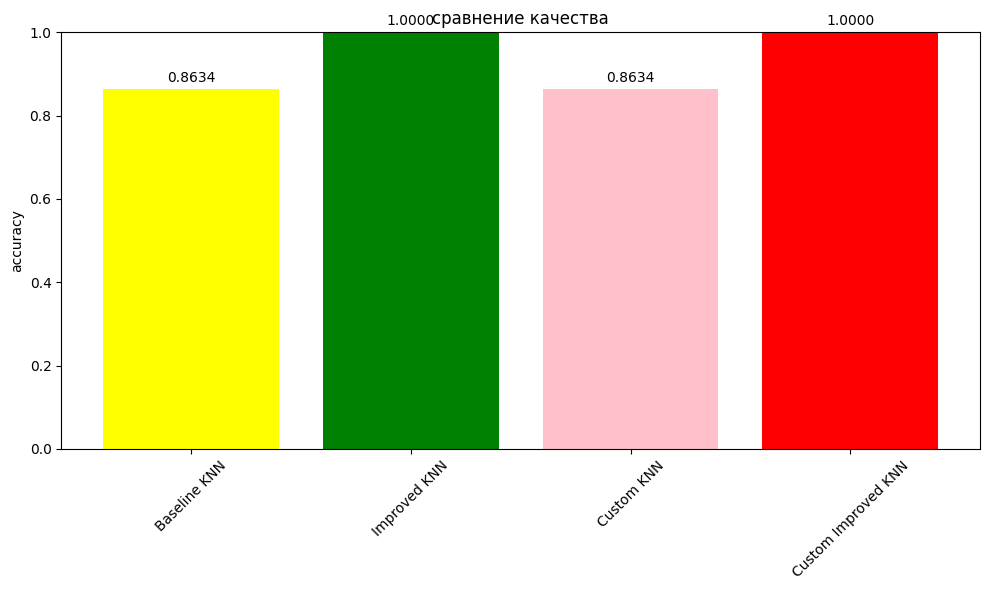

In [12]:
results_comparison = pd.DataFrame({
    'Model': ['Baseline KNN', 'Improved KNN', 'Custom KNN', 'Custom Improved KNN'],
    'Accuracy': [accuracy_baseline, accuracy_improved, accuracy_custom, accuracy_custom_improved]
})

print(results_comparison)

plt.figure(figsize=(10, 6))
models = results_comparison['Model']
accuracies = results_comparison['Accuracy']

bars = plt.bar(models, accuracies, color=['yellow', 'green', 'pink', 'red'])
plt.ylabel('accuracy')
plt.title('сравнение качества')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

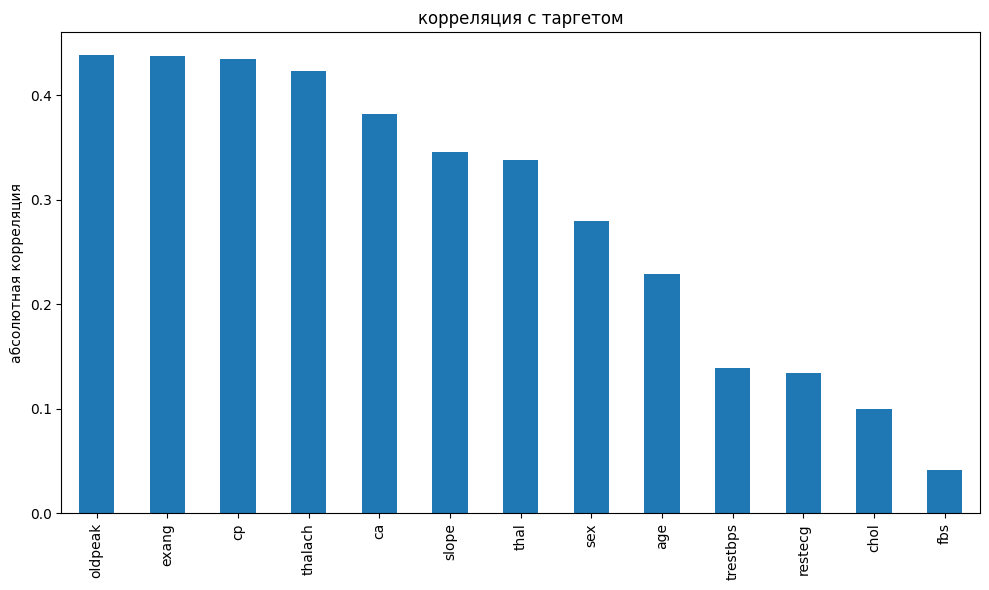

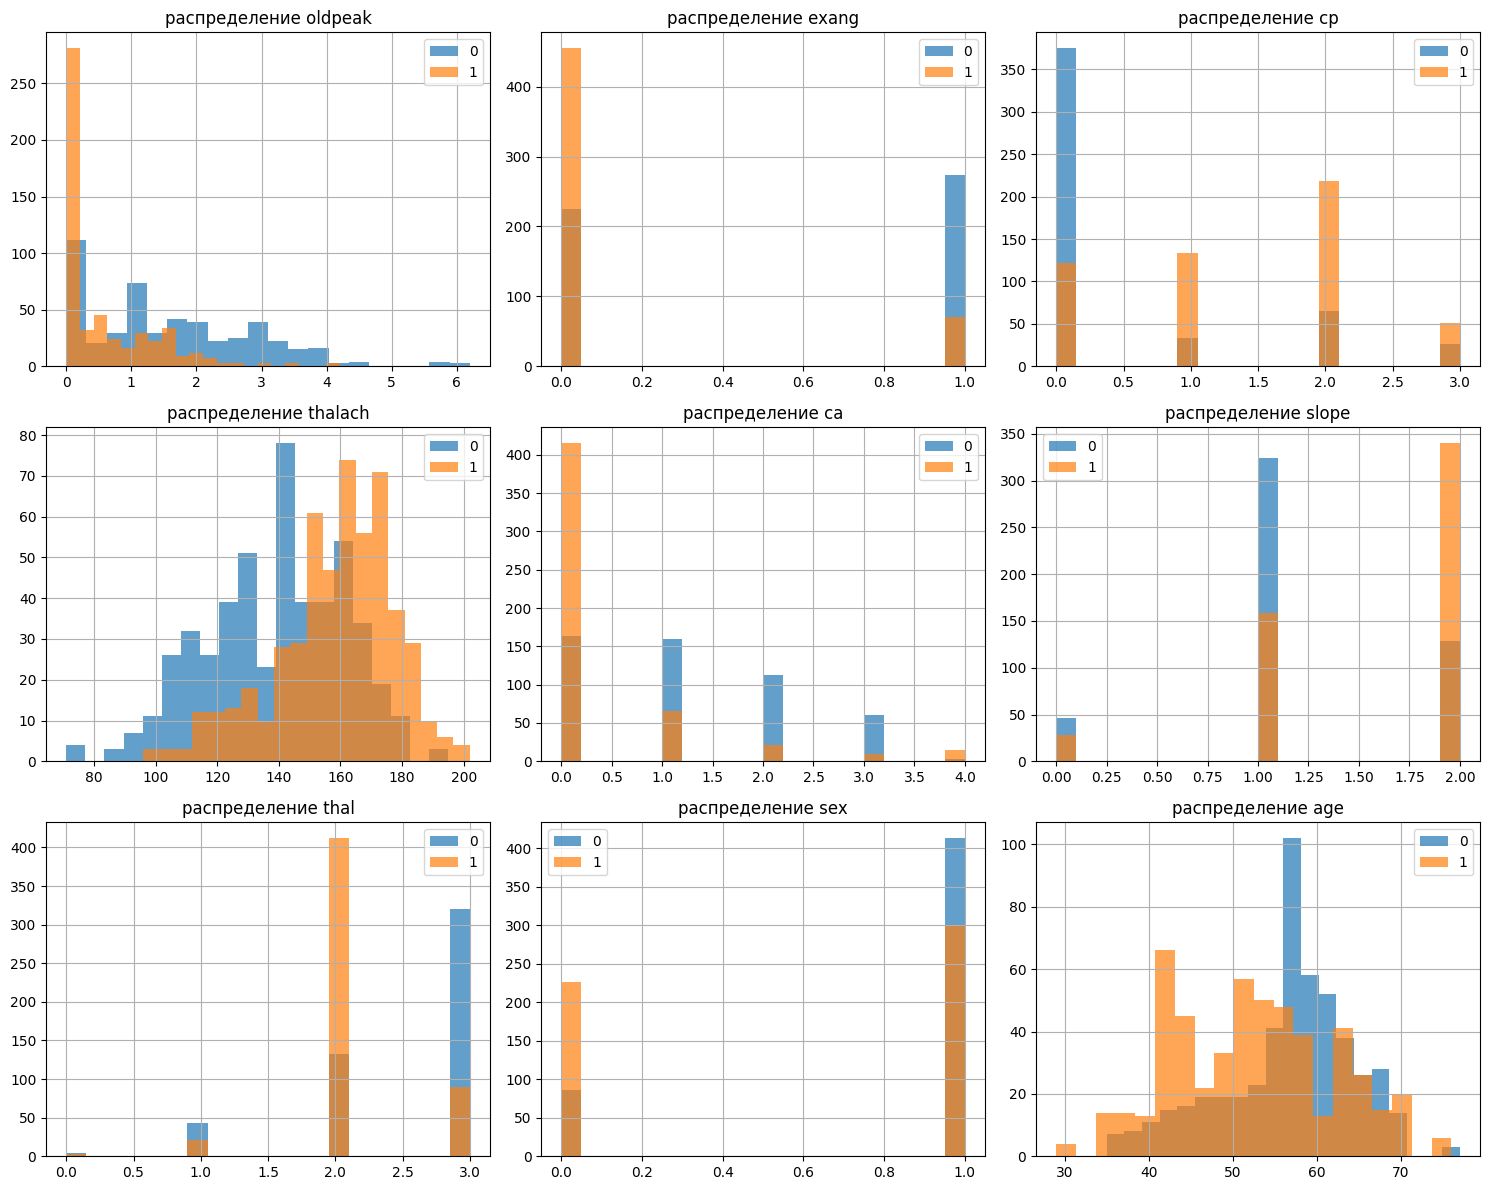

In [14]:
correlation_matrix = X.corrwith(y).abs().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlation_matrix.plot(kind='bar')
plt.title('корреляция с таргетом')
plt.ylabel('абсолютная корреляция')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

top_features = correlation_matrix.head(9).index

for i, feature in enumerate(top_features):
    if i < 9:
        df.groupby('target')[feature].hist(alpha=0.7, ax=axes[i], bins=20)
        axes[i].set_title(f'распределение {feature}')
        axes[i].legend(['0', '1'])

plt.tight_layout()
plt.show()

In [13]:
selector = SelectKBest(f_classif, k=8)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

knn_selected = KNeighborsClassifier(**grid_search.best_params_)
knn_selected.fit(X_train_selected, y_train)
y_pred_selected = knn_selected.predict(X_test_selected)

print(f"accuracy с отобранными фичами {accuracy_score(y_test, y_pred_selected):.4f}")

feature_scores = selector.scores_
important_features = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_scores
}).sort_values('importance', ascending=False)

print("\nважность признаков для KNN:")
print(important_features.head(10))

accuracy с отобранными фичами 1.0000

важность признаков для KNN:
     feature  importance
8      exang  225.328624
2         cp  208.676582
9    oldpeak  183.171126
7    thalach  181.200997
11        ca  141.317598
12      thal  112.600777
10     slope  106.559677
1        sex   53.252116
0        age   52.729760
3   trestbps   21.692157


In [16]:
custom_knn_selected = CustomKNN(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights'],
    metric=grid_search.best_params_['metric']
)
custom_knn_selected.fit(X_train_selected, y_train)
y_pred_custom_selected = custom_knn_selected.predict(X_test_selected)

accuracy_custom_selected = accuracy_score(y_test, y_pred_custom_selected)

print('\nфинальное сравнение')
print(f" библиотечная модель: {accuracy_improved:.4f}")
print(f"отбор признаков + библиотечная: {accuracy_score(y_test, y_pred_selected):.4f}")
print(f"отбор признаков + кастом: {accuracy_custom_selected:.4f}")
print(f"улучшение над бейзлайном: {accuracy_custom_selected - accuracy_baseline:.4f}")


финальное сравнение
 библиотечная модель: 1.0000
отбор признаков + библиотечная: 1.0000
отбор признаков + кастом: 1.0000
улучшение над бейзлайном: 0.1366


In [17]:
import numpy as np

cv_scores = grid_search.cv_results_['mean_test_score']
cv_stds = grid_search.cv_results_['std_test_score']
best_idx = grid_search.best_index_

print('\nанализ кросс-валидации')
print(f"лучший CV score: {cv_scores[best_idx]:.4f}")
print(f"стандартное отклонение лучшей модели: {cv_stds[best_idx]:.4f}")

print(f"\nразброс CV scores для всех моделей:")
print(f"минимальный: {cv_scores.min():.4f}")
print(f"максимальный: {cv_scores.max():.4f}")
print(f"средний: {cv_scores.mean():.4f}")
print(f"стандартное отклонение: {cv_scores.std():.4f}")

if cv_stds[best_idx] < 0.05:
    print("\nнизкое стандартное отклонение (< 0.05) - модель стабильна")
else:
    print(f"\nвысокое стандартное отклонение ({cv_stds[best_idx]:.4f}) - возможна нестабильность")


анализ кросс-валидации
лучший CV score: 0.9902
стандартное отклонение лучшей модели: 0.0137

разброс CV scores для всех моделей:
минимальный: 0.8390
максимальный: 0.9902
средний: 0.9219
стандартное отклонение: 0.0657

низкое стандартное отклонение (< 0.05) - модель стабильна


In [18]:
print("\nпроверка на переобучение:")

train_pred = knn_improved.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)

print(f"accuracy на трейне: {train_accuracy:.4f}")
print(f"accuracy на тесте: {accuracy_improved:.4f}")
print(f"разница (train - test): {train_accuracy - accuracy_improved:.4f}")

if train_accuracy - accuracy_improved > 0.1:
    print("разница > 0.1 - возможное переобучение")
elif train_accuracy - accuracy_improved > 0.05:
    print("разница > 0.05 - умеренное переобучение")
else:
    print("разница <= 0.05 - переобучения нет")


проверка на переобучение:
accuracy на трейне: 1.0000
accuracy на тесте: 1.0000
разница (train - test): 0.0000
разница <= 0.05 - переобучения нет


In [19]:
print("\nдополнительные метрики:")

from sklearn.metrics import roc_auc_score, f1_score
y_pred_proba = knn_improved.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_improved)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")

if roc_auc < 0.7:
    print("низкий ROC-AUC (< 0.7) - возможны проблемы")
elif roc_auc < 0.9:
    print("хороший ROC-AUC (0.7-0.9)")
else:
    print("отличный ROC-AUC (>= 0.9)")


дополнительные метрики:
ROC-AUC: 1.0000
F1-score: 1.0000
отличный ROC-AUC (>= 0.9)


## РЕГРЕССИЯ

Обучим базовую модель

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
train_id = train['Id']

y = train['SalePrice'].copy()
X = train.drop(['Id', 'SalePrice'], axis=1)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
missing_values = X.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])
pipeline.fit(X_train, y_train)

y_train_pred_pipe = pipeline.predict(X_train)
y_val_pred_pipe = pipeline.predict(X_val)

print(f"\nbase")
print(f"train R2 {r2_score(y_train, y_train_pred_pipe):.4f}")
print(f"test R2  {r2_score(y_val, y_val_pred_pipe):.4f}")


base
train R2 0.8370
test R2  0.8016


Теперь попробуем на улучшенном паплайне

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

all_data = pd.concat([X, X_test]).reset_index(drop=True)
y = train['SalePrice'].copy()
X = train.drop(['Id', 'SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)
y_log = np.log1p(y)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


def create_features(df):
    df = df.copy()
    df['TotalSF'] = df.get('TotalBsmtSF', 0) + df.get('1stFlrSF', 0) + df.get('2ndFlrSF', 0)
    df['TotalBath'] = df.get('FullBath', 0) + 0.5 * df.get('HalfBath', 0) + df.get('BsmtFullBath', 0) + 0.5 * df.get('BsmtHalfBath', 0)
    df['HouseAge'] = df.get('YrSold', 2023) - df.get('YearBuilt', 2000)
    df['RemodAge'] = df.get('YrSold', 2023) - df.get('YearRemodAdd', 2000)
    df['TotalPorchSF'] = df.get('OpenPorchSF', 0) + df.get('EnclosedPorch', 0) + df.get('3SsnPorch', 0) + df.get('ScreenPorch', 0)
    df['OverallQual_TotalSF'] = df.get('OverallQual', 5) * df.get('TotalSF', 1500)
    return df


def remove_outliers(df, y_series=None):
    df = df.copy()
    if y_series is not None:
        mask = (df['GrLivArea'] < 4500) & (np.expm1(y_series) < 300000)
        return df[mask], y_series[mask]
    return df


X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train_log)
X_test_no_outliers, y_test_no_outliers = remove_outliers(X_test, y_test_log)


def preprocess_data(X_train, X_test, y_train=None):
    X_train_proc = create_features(X_train)
    X_test_proc = create_features(X_test)
    numeric_cols_proc = X_train_proc.select_dtypes(include=[np.number]).columns
    categorical_cols_proc = X_train_proc.select_dtypes(exclude=[np.number]).columns
    numeric_imputer = SimpleImputer(strategy='median')
    X_train_proc[numeric_cols_proc] = numeric_imputer.fit_transform(X_train_proc[numeric_cols_proc])
    X_test_proc[numeric_cols_proc] = numeric_imputer.transform(X_test_proc[numeric_cols_proc])
    
    if len(categorical_cols_proc) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X_train_proc[categorical_cols_proc] = categorical_imputer.fit_transform(X_train_proc[categorical_cols_proc])
        X_test_proc[categorical_cols_proc] = categorical_imputer.transform(X_test_proc[categorical_cols_proc])
        
        for col in categorical_cols_proc:
            le = LabelEncoder()
            combined = pd.concat([X_train_proc[col], X_test_proc[col]], axis=0)
            le.fit(combined.astype(str).fillna('Missing'))
            X_train_proc[col] = le.transform(X_train_proc[col].astype(str).fillna('Missing'))
            X_test_proc[col] = le.transform(X_test_proc[col].astype(str).fillna('Missing'))
    
    scaler = StandardScaler()
    if len(numeric_cols_proc) > 0:
        X_train_proc[numeric_cols_proc] = scaler.fit_transform(X_train_proc[numeric_cols_proc])
        X_test_proc[numeric_cols_proc] = scaler.transform(X_test_proc[numeric_cols_proc])
    
    X_train_proc = X_train_proc.astype(float)
    X_test_proc = X_test_proc.astype(float)
    
    return X_train_proc, X_test_proc


X_train_processed, X_test_processed = preprocess_data(X_train_no_outliers, X_test_no_outliers, y_train_no_outliers)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_processed, y_train_no_outliers)
y_train_pred_log = knn_model.predict(X_train_processed)
y_test_pred_log = knn_model.predict(X_test_processed)
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train_no_outliers)
y_test_actual = np.expm1(y_test_no_outliers)

print(f"train RMSE {np.sqrt(mean_squared_error(y_train_actual, y_train_pred)):.2f}")
print(f"test RMSE  {np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):.2f}")
print(f"train MAE  {mean_absolute_error(y_train_actual, y_train_pred):.2f}")
print(f"test MAE   {mean_absolute_error(y_test_actual, y_test_pred):.2f}")
print(f"train R2   {r2_score(y_train_actual, y_train_pred):.4f}")
print(f"test R2    {r2_score(y_test_actual, y_test_pred):.4f}")

train RMSE 20963.87
test RMSE  25727.39
train MAE  15552.00
test MAE   19207.42
train R2   0.8339
test R2    0.7773


Снизим переобучение без потери качества

In [17]:
X_train_processed, X_test_processed = preprocess_data(X_train_no_outliers, X_test_no_outliers, y_train_no_outliers)

param_grid = {
    'n_neighbors': [7, 9, 11, 13, 15],
    'weights': ['uniform'],
    'p': [2],
    'leaf_size': [20, 30, 40]
}

knn_model = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

knn_model.fit(X_train_processed, y_train_no_outliers)
y_train_pred_log = knn_model.predict(X_train_processed)
y_test_pred_log = knn_model.predict(X_test_processed)
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train_no_outliers)
y_test_actual = np.expm1(y_test_no_outliers)
print(f"params {knn_model.best_params_}")
print(f"train RMSE {np.sqrt(mean_squared_error(y_train_actual, y_train_pred)):.2f}")
print(f"test RMSE {np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):.2f}")
print(f"train MAE  {mean_absolute_error(y_train_actual, y_train_pred):.2f}")
print(f"test MAE   {mean_absolute_error(y_test_actual, y_test_pred):.2f}")
print(f"train R2 {r2_score(y_train_actual, y_train_pred):.4f}")
print(f"test R2 {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"train-test {r2_score(y_train_actual, y_train_pred) - r2_score(y_test_actual, y_test_pred):.4f}")


params {'leaf_size': 20, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
train RMSE 22775.24
test RMSE 25674.61
train MAE  16558.31
test MAE   19083.55
train R2 0.8040
test R2 0.7783
train-test 0.0257


Получили хорошие результаты, теперь перейдем к своей реализации

In [23]:
class MyKNNRegressor:
    def __init__(self, n_neighbors=5, weights='uniform', p=2):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.X_train = None
        self.y_train = None
        
    def _distance(self, x1, x2):
        if self.p == 1:
            return np.sum(np.abs(x1 - x2), axis=1)
        elif self.p == 2:
            return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))
        else:
            return np.power(np.sum(np.power(np.abs(x1 - x2), self.p), axis=1), 1/self.p)
    
    def fit(self, X, y):
        self.X_train = X.astype(float)
        self.y_train = y.astype(float)
        return self
    
    def predict(self, X):
        X = X.astype(float)
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i in range(n_samples):
            distances = self._distance(self.X_train, X[i])
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_distances = distances[nearest_indices]
            nearest_targets = self.y_train[nearest_indices]
            
            if self.weights == 'uniform':
                predictions[i] = np.mean(nearest_targets)
            elif self.weights == 'distance':
                if np.any(nearest_distances == 0):
                    mask = nearest_distances == 0
                    predictions[i] = np.mean(nearest_targets[mask])
                else:
                    weights = 1.0 / (nearest_distances + 1e-8)
                    weights /= np.sum(weights)
                    predictions[i] = np.sum(weights * nearest_targets)
        
        return predictions

my_knn = MyKNNRegressor(n_neighbors=7, weights='uniform', p=2)
my_knn.fit(X_train_processed.values, y_train_no_outliers.values)

y_train_pred_log = my_knn.predict(X_train_processed.values)
y_test_pred_log = my_knn.predict(X_test_processed.values)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

y_train_actual = np.expm1(y_train_no_outliers.values)
y_test_actual = np.expm1(y_test_no_outliers.values)

print("my")
print(f"train RMSE {np.sqrt(mean_squared_error(y_train_actual, y_train_pred)):.2f}")
print(f"test RMSE {np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):.2f}")
print(f"train MAE {mean_absolute_error(y_train_actual, y_train_pred):.2f}")
print(f"test MAE   {mean_absolute_error(y_test_actual, y_test_pred):.2f}")
print(f"train R2  {r2_score(y_train_actual, y_train_pred):.4f}")
print(f"test R2  {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"train-test {r2_score(y_train_actual, y_train_pred) - r2_score(y_test_actual, y_test_pred):.4f}")

my
train RMSE 22216.69
test RMSE 25583.20
train MAE 16224.62
test MAE   18918.14
train R2  0.8135
test R2  0.7798
train-test 0.0336


Получили неплохие результаты. Так как KNN не линейна, мы можем использовать первый пайплайн и скорее всего R2 будет выше

In [28]:

def remove_outliers_iqr(X_df, y_series=None, threshold=3):
    X_df = X_df.copy()
    mask = pd.Series(True, index=X_df.index)
    
    for col in X_df.select_dtypes(include=[np.number]).columns:
        if col in X_df.columns:
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            col_mask = (X_df[col] >= lower_bound) & (X_df[col] <= upper_bound)
            mask = mask & col_mask
    
    if y_series is not None:
        Q1_y = y_series.quantile(0.25)
        Q3_y = y_series.quantile(0.75)
        IQR_y = Q3_y - Q1_y
        lower_bound_y = Q1_y - threshold * IQR_y
        upper_bound_y = Q3_y + threshold * IQR_y
        mask_y = (y_series >= lower_bound_y) & (y_series <= upper_bound_y)
        mask = mask & mask_y
    
    if y_series is not None:
        return X_df[mask], y_series[mask]
    return X_df[mask]

X_no_outliers, y_no_outliers = remove_outliers_iqr(X, y, threshold=3)

X_train, X_val, y_train, y_val = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MyKNNRegressor(n_neighbors=7, weights='uniform', p=2))
])

pipeline.fit(X_train, y_train)

y_train_pred_pipe = pipeline.predict(X_train)
y_val_pred_pipe = pipeline.predict(X_val)

print(f"\nmy 2")
print(f"train R2 {r2_score(y_train, y_train_pred_pipe):.4f}")
print(f"test R2  {r2_score(y_val, y_val_pred_pipe):.4f}")
print(f"train- test {r2_score(y_train, y_train_pred_pipe) - r2_score(y_val, y_val_pred_pipe):.4f}")


my 2
train R2 0.8963
test R2  0.8320
train- test 0.0642
